In [174]:
import tensorflow as tf
import numpy as np
from math import sqrt, exp, log
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm         # tqdm is a nice library to visualize ongoing loops
import datetime
from mpl_toolkits.mplot3d import Axes3D 
import random as rd
import pandas as pd
# followint lines are used for indicative typing
from typing import Tuple
class Vector: pass

In [175]:
from dolo import *

In [176]:
model = yaml_import('rbc.yaml')

On commence par importer les équations du modèle. Pour cela on défini deux fonctions "arbitrage" et "transition". 

In [177]:
#from dolo.compiler.factories import get_factory
#fac = get_factory(model, 'transition')
#import dolang
#transition = dolang.function_compiler.compile_factory(fac)        # Les deux équations de transition
#source = dolang.function_compiler.to_source(transition)
#print( source )

def transition(m, s, x, M, p):
    e_z_m1_ = m[0]
    z_m1_ = s[0]
    k_m1_ = s[1]
    n_m1_ = x[0]
    i_m1_ = x[1]
    e_z__0_ = M[0]
    beta_ = p[0]
    sigma_ = p[1]
    eta_ = p[2]
    chi_ = p[3]
    delta_ = p[4]
    alpha_ = p[5]
    rho_ = p[6]
    zbar_ = p[7]
    sig_z_ = p[8]
    y_m1_ = ((tf.exp(z_m1_)) * ((k_m1_) ** (alpha_))) * ((n_m1_) ** ((1.0) - (alpha_)))       # ajout de tf.
    c_m1_ = (y_m1_) - (i_m1_)
    rk_m1_ = ((alpha_) * (y_m1_)) / (k_m1_)
    w_m1_ = (((1.0) - (alpha_)) * (y_m1_)) / (n_m1_)
    z__0_ = (rho_) * (z_m1_) + e_z__0_
    k__0_ = ((1.0) - (delta_)) * (k_m1_) + i_m1_
    
    return (z__0_,k__0_)

In [178]:
#from dolo.compiler.factories import get_factory
#fac = get_factory(model, 'arbitrage')             # fac is a FlatFunctionFactory types
#import dolang
#arbitrage = dolang.function_compiler.compile_factory(fac)         # Les deux équations d'abitrage
#source = dolang.function_compiler.to_source(arbitrage)
#print( source )

def arbitrage(m, s, x, M, S, X, p):
    e_z__0_ = m[0]
    z__0_ = s[0]
    k__0_ = s[1]
    n__0_ = x[0]
    i__0_ = x[1]
    e_z__1_ = M[0]
    z__1_ = S[0]
    k__1_ = S[1]
    n__1_ = X[0]
    i__1_ = X[1]
    beta_ = p[0]
    sigma_ = p[1]
    eta_ = p[2]
    chi_ = p[3]
    delta_ = p[4]
    alpha_ = p[5]
    rho_ = p[6]
    zbar_ = p[7]
    sig_z_ = p[8]
    y__0_ = ((tf.exp(z__0_)) * ((k__0_) ** (alpha_))) * ((n__0_) ** ((1.0) - (alpha_)))          # Ajour de tf.
    y__1_ = ((tf.exp(z__1_)) * ((k__1_) ** (alpha_))) * ((n__1_) ** ((1.0) - (alpha_)))
    c__0_ = (y__0_) - (i__0_)
    c__1_ = (y__1_) - (i__1_)
    rk__0_ = ((alpha_) * (y__0_)) / (k__0_)
    rk__1_ = ((alpha_) * (y__1_)) / (k__1_)
    w__0_ = (((1.0) - (alpha_)) * (y__0_)) / (n__0_)
    w__1_ = (((1.0) - (alpha_)) * (y__1_)) / (n__1_)
    out__0_ = (((chi_) * ((n__0_) ** (eta_))) * ((c__0_) ** (sigma_))) - (w__0_)
    out__1_ = (1.0) - (((beta_) * (((c__0_) / (c__1_)) ** (sigma_))) * ((1.0) - (delta_) + rk__1_))

    # if c__0_.numpy().any() > y__0_.numpy().any() or c__1_.numpy().any() > y__1_.numpy().any() :
    #     print('Il éxiste c > y problème')
    
    # if (c__0_.numpy().any()/y__0_.numpy().any()) == 0 or (c__1_.numpy().any()/y__1_.numpy().any()) == 0 : 
    #     print("La part d'output consommée est nulle")

    return (out__0_,out__1_)

On cherche ensuite a importer tous les paramètres et conditions de steady-state via "calibration"

In [179]:
calibration = model.calibration

m0 = calibration['exogenous']
s0 = calibration['states']
x0 = calibration['controls']

parameters = calibration['parameters']

In [180]:
print(m0)
print(s0)
print(x0)

[0.]
[0.         9.35497829]
[0.33       0.23387446]


Enfin on importe les domaines des variables d'état. 

In [181]:
domain = model.domain

# On transforme le dictionnaire en liste une liste de domaines et une liste avec les noms des états
list_domain=[]
list_keys=[]
for clef,valeur in domain.items():
    list_domain.append(valeur)
    list_keys.append(clef)

# Définition du type du modèle

In [182]:
# model_type = 'Non Mixte'
# for key in list_keys :
#     if isinstance(calibration['e_'+key],(int,float)):
#         model_type = 'Mixte' 

# endogenous_states = []         # Deux listes contenants les noms des variables endogènes et exogènes contenues dans s
# exogenous_states = []          # Cette redistribution permet le bon fonctionnement de la suite de mon programme

# if model_type == 'Non Mixte':
#     endogenous_states = list_keys
#     exogenous_states = []

# if model_type == 'Mixte':
#     for key in list_keys :
#         if isinstance(calibration['e_'+key],(int,float)):
#             exogenous_states.append(key)
#         else:
#             endogenous_states.append(key)

# # Question pour Pablo : existe-t-il des modèles pour lesquels dans les variables exogènes on a des variables + des shocks de variables ??? 
# # Ou est-ce toujours soit l'un soit l'autre ?

Pour la suite on va supposer que le modèle est sous le format suivant : 

- m représente les chocs des variables exogènes.
- s représente les états (variables exogènes suivies des variables endogènes).
- x représente les variables de contrôle.
- Dans la liste des paramètres, les déviations standard des chocs sont dans les dernières positions et dans le même ordre que les chocs dans m.
- La liste de paramètres est ordonnée de cette manière : [paramètres des variables endogènes, valeurs initiales des variables endogènes, paramètres des variables exogènes, valeurs initiales des variables exogènes, chocs des variables exogènes.]

# Construction du réseau neuronal

In [183]:
layers = [
    tf.keras.layers.Dense(32, activation='sigmoid', input_dim=2, bias_initializer='he_uniform'),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(2, activation=tf.keras.activations.linear)
]
perceptron = tf.keras.Sequential(layers)

In [184]:
def dr(state: Vector):            # dr = decision rule   

    # We normalize state variables between -1 and 1, taking into account the hypothesis above.
    a = [variable for variable in state]
    for i in range(len(m0)):      # Les états exogènes dont l'évolution est régis par des chocs
        a[i] = a[i]/(parameters[-(len(m0)-i)]/(1-parameters[-len(m0)-(len(m0)-i)]**2)**0.5)/2     #parameters[-len(m0)-(len(m0)-i)] = rho
    for i in range(len(s0)-len(m0)):      # Les états endogènes
        a[len(m0)+i] = (a[i]-list_domain[i][0])/(list_domain[i][1]-list_domain[i][0])*2.0-1.0
    
    # we prepare input to the perceptron
    s = tf.concat([_e[:,None] for _e in a], axis=1) # equivalent to np.column_stack

    x = perceptron(s) # n x len(state) matrix             # The deltas are hidden in this perceptron function
    
    # We apply exp because this ensures that controls are always positive
    x = tf.exp(x)
    
    return x

In [185]:
state_vec=[]
for i in range(len(s0)):
    variable_vec = np.linspace(list_domain[i][0], list_domain[i][1], 100)
    state_vec.append(variable_vec)

state_vec = tf.convert_to_tensor(state_vec)

# Avec une autre structure de x on ferait ça

# state_vec = np.linspace([list_domain[0][0],list_domain[1][0]], [list_domain[0][1],list_domain[1][1]], 100)

# state_vec = np.asarray(state_vec)
# print(state_vec)

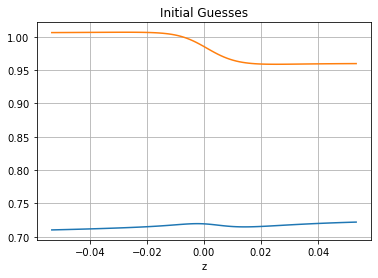

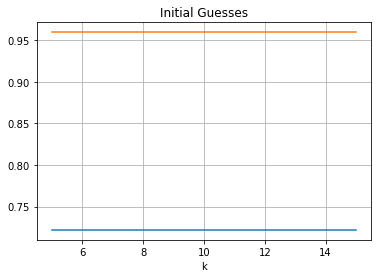

In [186]:
mat=[]
for i in range(len(state_vec)):

    s = []
    if i!=0:
        for j in range(i):
            s.append(((list_domain[j][1]-list_domain[j][0])/2)*(state_vec[j]/state_vec[j]))     # La moyenne 
    
    s.append(state_vec[i])     # La vraie valeur

    if i!=len(state_vec):
        for j in range(i+1,len(state_vec)):
            s.append(((list_domain[j][1]-list_domain[j][0])/2)*(state_vec[j]/state_vec[j]))     # La moyenne
    
    x = dr(np.asarray(s))
    mat.append(x)

# ici on a plot les controls en fonction de chaque variables d'état (les autres étant fixes et valants leurs moyennes)
# On obtient donc len(s0) graphs différents 

for j in range(len(state_vec)):
    plt.figure()
    plt.plot(state_vec[j],mat[j])
    plt.xlabel(list_keys[j])
    plt.title("Initial Guesses")
    plt.grid()

In [187]:
def Residuals(shocks: Vector, state: Vector):

    # all inputs are expected to have the same size n
    size = tf.size(state[0])

    # Controls at t 
    x = dr(state)
    
    i = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    n = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    for j in range(size):
        i = i.write(j,x[tf.convert_to_tensor(j)][tf.convert_to_tensor(0)])
        n = n.write(j,x[tf.convert_to_tensor(j)][tf.convert_to_tensor(1)])
    i = i.stack()
    n = n.stack()
    control = (i,n)

    # State at t+1
    State = transition(tf.convert_to_tensor([0]), state, control, shocks, parameters)        # Je défini le choc à t de manière arbitraire à 0 car il n'est pas utile ici

    # Controls at t+1
    X = dr(State)

    I = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    N = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    for j in range(size):
        I = I.write(j,x[tf.convert_to_tensor(j)][tf.convert_to_tensor(0)])
        N = N.write(j,x[tf.convert_to_tensor(j)][tf.convert_to_tensor(1)])
    I = I.stack()
    N = N.stack()
    Control = (I,N)
    
    # Residuals, vector of size depending on the arbitrage function used in the model
    R = arbitrage(tf.convert_to_tensor([0]), state, control, shocks, State, Control, parameters)

    return R

In [188]:
def Ξ(n): # objective function for DL training
    
    state = []
    for i in range(len(m0)):      # Les états exogènes dont l'évolution est régis par des chocs
        variable = tf.random.normal(shape=(n,), stddev=(parameters[-(len(m0)-i)]/(1-parameters[-len(m0)-(len(m0)-i)]**2)**0.5))     #parameters[-len(m0)-(len(m0)-i)] = rho
        state.append(variable)

    for i in range(len(s0)-len(m0)):      # Les états endogènes
        variable = tf.random.uniform(shape=(n,), minval=list_domain[len(m0)+i][0], maxval=list_domain[len(m0)+i][1])
        state.append(variable)
    
    state = tuple(state)
    # J'ai donc bien automatisé le processus "randomly drawing current states" mais grâce à des hypothèses fortes sur la structure du modèle.

    shocks_1 = []
    shocks_2 = []
    for i in range(len(m0)):
        shocks_1.append(tf.random.normal(shape=(n,), stddev=parameters[-(len(m0)-i)]))      # Fonctionne grâce aux hypothèses faites sur la structure du modèle
        shocks_2.append(tf.random.normal(shape=(n,), stddev=parameters[-(len(m0)-i)]))
    
    # residuals for n random grid points under 2 realizations of shocks
    R_e1 = Residuals(shocks_1, state)
    R_e2 = Residuals(shocks_2, state)

    # construct all-in-one expectation operator
    R_squared = 0         
    for i in range(len(R_e1)):
        R_squared = R_squared + R_e1[i]*R_e2[i]
    
    
    # compute average across n random draws
    return tf.reduce_mean(R_squared)

In [189]:
n = 128
v = Ξ(n)
v.numpy()

41.60456

# Model Training


In [190]:
θ = perceptron.trainable_variables
#print( str(θ)[:1000] ) # we truncate output

In [191]:
from tensorflow.keras.optimizers import Adam, SGD     # Choice of otpimizer

optimizer = Adam()
# optimizer = SGD(λ=0.1) # SGD can be used in place of Adam

In [192]:
@tf.function
def training_step():

    with tf.GradientTape() as tape:
        xx = Ξ(n)

    grads = tape.gradient(xx, θ)
    optimizer.apply_gradients(zip(grads,θ))

    return xx

In [193]:
def train_me(K):

    vals = []
    for k in tqdm(tf.range(K)):
        val = training_step()
        vals.append(val.numpy())
        vals.append(val.numpy())
        
    return vals

In [194]:
results = train_me(20000)

100%|██████████| 20000/20000 [21:50<00:00, 15.26it/s]


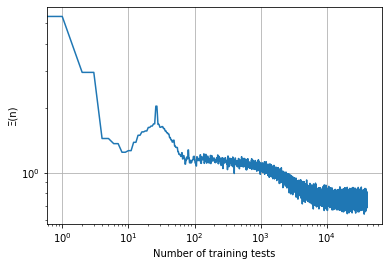

In [195]:
plt.plot(np.sqrt(results))
plt.xlabel('Number of training tests')
plt.ylabel('Ξ(n)')
plt.xscale('log')
plt.yscale('log')
plt.grid()

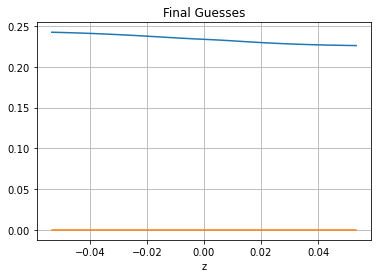

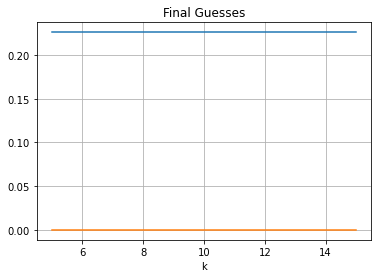

In [196]:
state_vec=[]
for i in range(len(s0)):
    variable_vec = np.linspace(list_domain[i][0], list_domain[i][1], 100)
    state_vec.append(variable_vec)

state_vec = np.asarray(state_vec)

mat=[]
for i in range(len(state_vec)):

    s = []
    if i!=0:
        for j in range(i):
            s.append(((list_domain[j][1]-list_domain[j][0])/2)*(state_vec[j]/state_vec[j]))     # La moyenne 
    
    s.append(state_vec[i])     # La vraie valeur

    if i!=len(state_vec):
        for j in range(i+1,len(state_vec)):
            s.append(((list_domain[j][1]-list_domain[j][0])/2)*(state_vec[j]/state_vec[j]))     # La moyenne
    
    x = dr(np.asarray(s))
    mat.append(x)

# ici on a plot les controls en fonction de chaque variables d'état (les autres étant fixes et valants leurs moyennes)
# On obtient donc len(s0) graphs différents 

for j in range(len(state_vec)):
    plt.figure()
    plt.plot(state_vec[j],mat[j])
    plt.xlabel(list_keys[j])
    plt.title("Final Guesses")
    plt.grid()

# Simulation

# Stochastic simulations

Our goal is to write a function that simulates our model N times for a certain number of time periods T.

In [197]:
def simulate(model, dr, N, T):

    calibration = model.calibration
    m0 = calibration['exogenous']
    s0 = calibration['states']
    x0 = calibration['controls']
    parameters = calibration['parameters']

    simulations = []

    for n in range(N) :

        result = []
        #result.append([m0,s0,x0])          # Initial state
        s=[]
        for variable in s0:
            s.append([variable])            # Stick to good format
        m = m0

        for t in range(T) :

            control = dr(s)             # dr demande une liste de liste de variable
            x = []
            for i in range(len(control[0])):
                x.append([control[0][i].numpy()])
            
            for i in range(len(s)):
                s[i]=s[i][0]

            result.append([m,s,x])

            m = []
            for i in range(len(m0)):
                m.append(tf.random.normal(shape=(1,) , stddev=parameters[-(len(m0)-i)]).numpy())              # We define the shock for the next time period 
            
            state = transition(m,s,x,m,parameters)       # transition demande une liste de variables
            s = []
            for variable in state:
                s.append(variable)
        
        simulations.append(result)
    simulations = np.asarray(simulations)

    return simulations                    # N x T x (len(m0)+len(s0)+len(x0)) matrix

In [198]:
sim = simulate(model,dr,500,40)

    Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


    Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
    Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


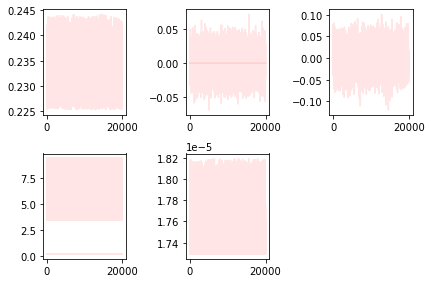

In [199]:
plt.figure()

mat = []
for i in range(len(sim[0][0])):
    mat.append([])
for i in range(len(sim[0][0])):
    for j in range(len(sim[0][0][i])):
        mat[i].append([])

for i in range(len(sim)):
    for j in range(len(sim[i])):
        for v in range(len(sim[i][j])):
            for l in range(len(sim[i][j][v])):
                mat[v][l].append(sim[i][j][v][l])

for v in range(len(mat)+1):
    for l in range(len(mat[v-1])):
        plt.subplot(231+v+l)
        plt.plot(mat[v-1][l], color='red', alpha=0.1)

# plt.subplot(331)
# plt.title('Shocks')
# plt.subplot(332)
# plt.title('Technological progress')
# plt.subplot(333)
# plt.title('Capital')
# plt.subplot(334)
# plt.title('Investment')
# plt.subplot(335)
# plt.title('Labor')

plt.tight_layout()